# Model Staff

In this notebook we run regression models with the full dataframe of features to predict the number of COVID19 cases among prisons staff by State per month.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Features-Selection" data-toc-modified-id="Features-Selection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Features Selection</a></span><ul class="toc-item"><li><span><a href="#Nulls" data-toc-modified-id="Nulls-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Nulls</a></span></li><li><span><a href="#Correlation-Heatmap" data-toc-modified-id="Correlation-Heatmap-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Correlation Heatmap</a></span></li><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Categorical Features</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Custom-Train-Split" data-toc-modified-id="Custom-Train-Split-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Custom Train Split</a></span></li><li><span><a href="#Scaling" data-toc-modified-id="Scaling-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Scaling</a></span></li></ul></li></ul></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Linear Regression</a></span><ul class="toc-item"><li><span><a href="#Lasso" data-toc-modified-id="Lasso-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#Ridge" data-toc-modified-id="Ridge-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ridge</a></span></li></ul></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Bagged-Decision-Tree" data-toc-modified-id="Bagged-Decision-Tree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bagged Decision Tree</a></span></li><li><span><a href="#K-Neighbors-Regressor" data-toc-modified-id="K-Neighbors-Regressor-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>K Neighbors Regressor</a></span></li><li><span><a href="#Neural-Network" data-toc-modified-id="Neural-Network-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Neural Network</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Results</a></span></li></ul></div>

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Features Selection

The dataset created in the previous notebook has to get trimmed and organized for different models we want to run. 

In [2]:
df = pd.read_csv('./data/data_clean_complete.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 44 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   name                                                510 non-null    object 
 1   state                                               510 non-null    object 
 2   staff_tests                                         340 non-null    float64
 3   total_staff_cases                                   510 non-null    float64
 4   staff_recovered                                     500 non-null    float64
 5   total_staff_deaths                                  510 non-null    float64
 6   prisoner_tests                                      500 non-null    float64
 7   total_prisoner_cases                                510 non-null    float64
 8   prisoners_recovered                                 500 non-null    float64
 9  

As mentioned, some of features present in the dataset are not useful for the problem or might result redundant. For this reason I proceed to drop them.

In [4]:
df.drop(columns=['state'], inplace= True)

In [5]:
df.isnull().sum()

name                                                    0
staff_tests                                           170
total_staff_cases                                       0
staff_recovered                                        10
total_staff_deaths                                      0
prisoner_tests                                         10
total_prisoner_cases                                    0
prisoners_recovered                                    10
total_prisoner_deaths                                   0
as_of_date                                              0
year                                                    0
month                                                   0
region                                                  0
civ_death                                               0
civ_cases                                               0
civ_hosp                                                0
civ_tests                                               0
Design capacit

Remove the federal record, keeping only States.

In [6]:
df.drop(df.loc[df['name']== 'Federal'].index, inplace=True)

### Nulls
Drop columns that still have nulls.

In [7]:
df.drop(columns=['staff_tests', 'staff_recovered', 'prisoner_tests', 'prisoners_recovered'], inplace= True)

### Correlation Heatmap

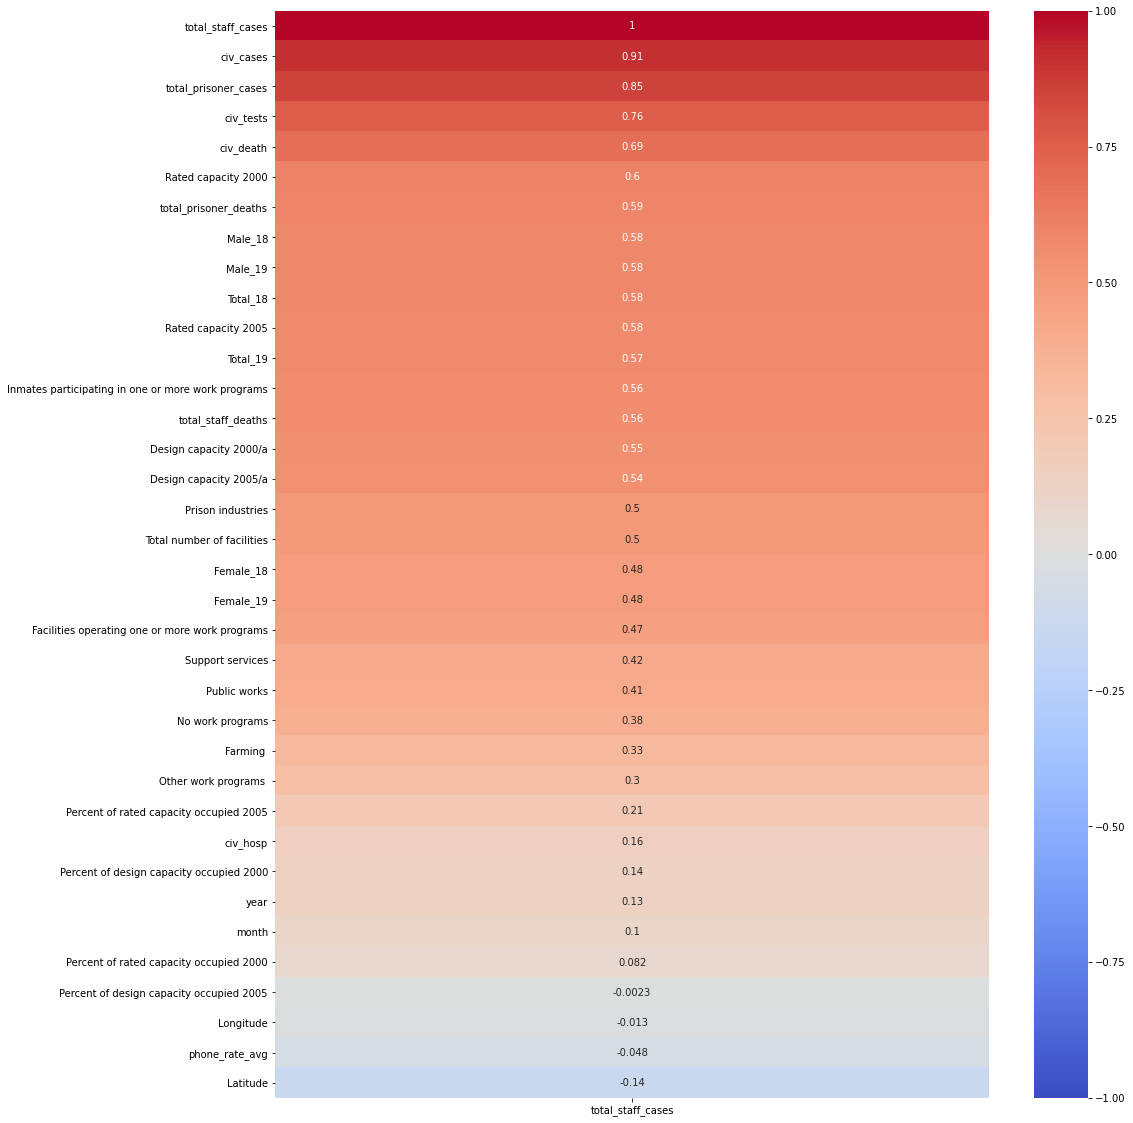

In [8]:
plt.figure(figsize= (16, 20))

correlation = df.corr()[['total_staff_cases']].sort_values(by=['total_staff_cases'],ascending=False)

sns.heatmap(data= correlation,
            cmap= 'coolwarm',      
            annot= True,
           vmax= 1,
           vmin= -1);

As staff members are also civilian, we can see the correlation with civilian cases being very high.

Also, the high correlation with pisoners cases, show how they are at the intersection between the two groups.

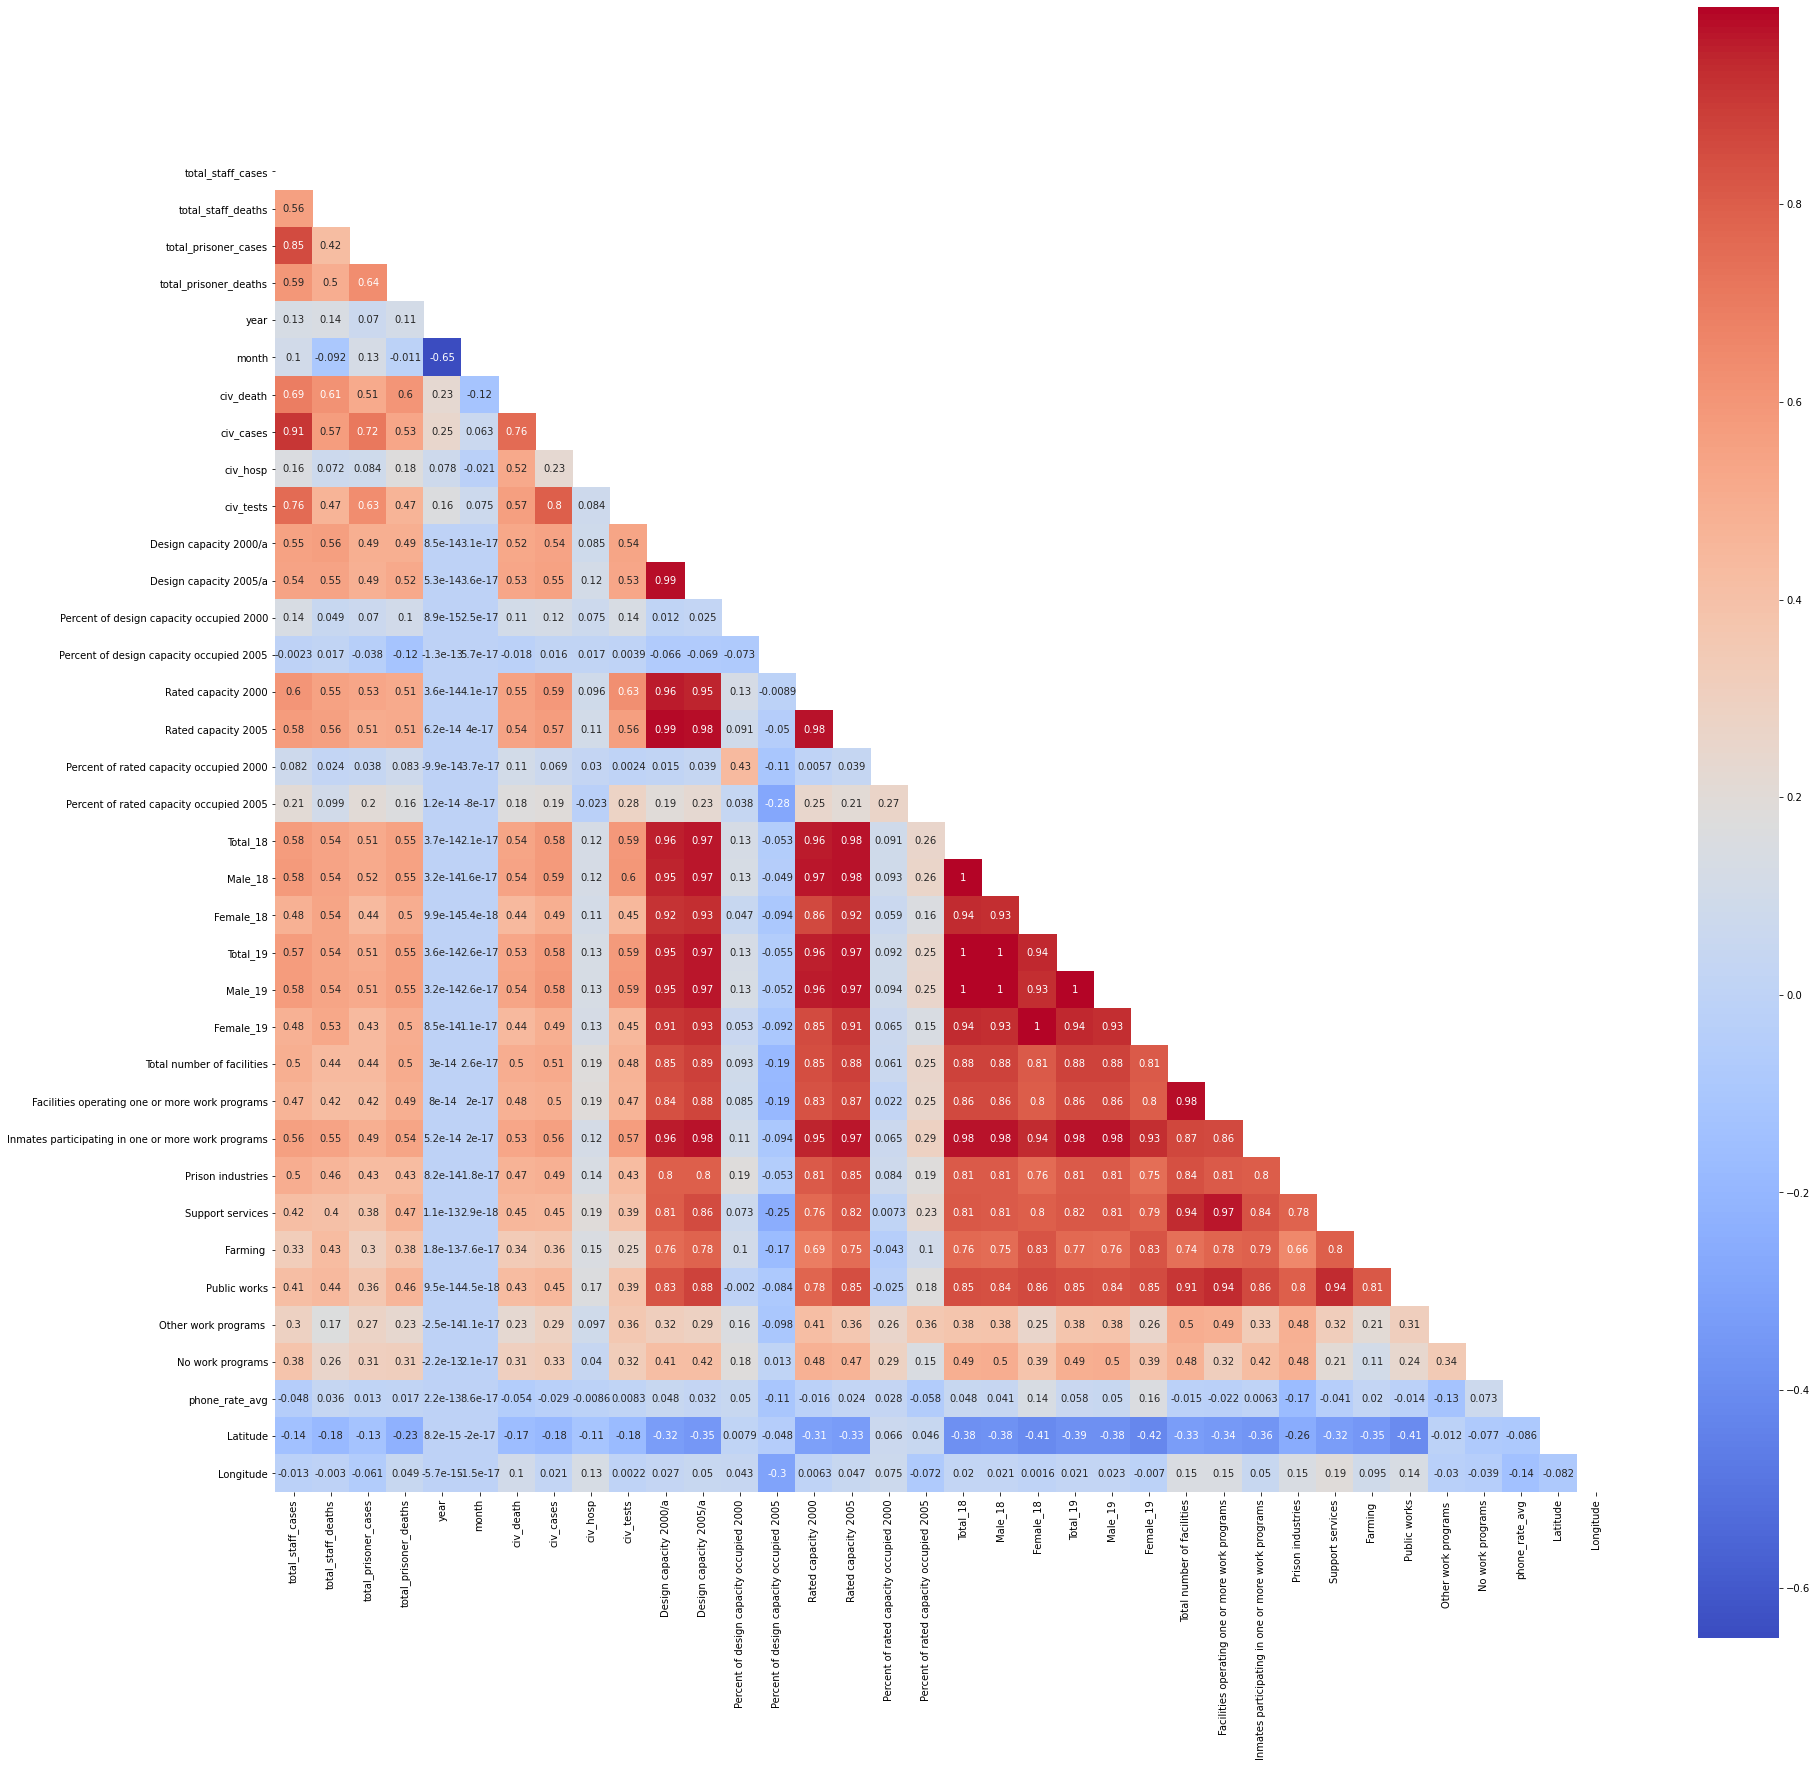

In [9]:
plt.figure(figsize= (30, 30))
# Get correlation of variables.
correlation = df.corr()

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)]= True
# Plot our correlation heatmap, while masking the upper triangle to be white.
sns.heatmap(data= correlation,       #data to plot
            mask= mask,
            square= True,      #boolean for asuqare plot or not
            cmap= 'coolwarm',      # color palette
            annot = True);     # show values in 

### Categorical Features

State and Region are still objects and we want to transform them in binary features so that we can feed them into our regression models.

In [10]:
df = pd.get_dummies(data = df, columns= ['region', 'name'], drop_first=True)

In [11]:
df.drop(columns=['as_of_date'], inplace= True)

### Preprocessing

To begin modeling we realize some custom adjustment have to be made.

#### Custom Train Split

In particular, we decide to create our custo train and test split, using all data from March to December 2020 as a train and testing the models on January 2021 records.

This is achieved by srting the dataframe and filtering it per year.

*Note: this is possible because we have no overlap between months in 2020 and 2021.*

In [12]:
df.sort_values(by= ['month'], ascending=[True], inplace= True)

In [13]:
df.head()

,total_staff_cases,total_staff_deaths,total_prisoner_cases,total_prisoner_deaths,year,month,civ_death,civ_cases,civ_hosp,civ_tests,...,name_South Dakota,name_Tennessee,name_Texas,name_Utah,name_Vermont,name_Virginia,name_Washington,name_West Virginia,name_Wisconsin,name_Wyoming
259,232.0,0.0,217.0,2.0,2021.0,1.0,1229,66249,0,518554,...,0,0,0,0,0,0,0,0,0,0
269,25.0,0.0,3.0,0.0,2021.0,1.0,272,12394,677,162660,...,0,0,0,0,0,0,0,0,0,0
249,1.0,0.0,68.0,12.0,2021.0,1.0,1258,59190,502,196032,...,0,0,0,0,0,0,0,0,0,0
239,49.0,0.0,243.0,2.0,2021.0,1.0,877,46505,2444,0,...,0,0,0,0,0,0,0,0,0,0
229,478.0,0.0,2498.0,16.0,2021.0,1.0,2507,81517,0,1262392,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_train = df[df["year"] == 2020]
df_test = df[df["year"] == 2021]

In [15]:
X_train = df_train.drop(columns=['total_staff_cases', 'total_staff_deaths'])
X_test = df_test.drop(columns=['total_staff_cases', 'total_staff_deaths'])

y_train = df_train['total_staff_cases']
y_test = df_test['total_staff_cases']

#### Scaling

Than we scale our Features sets.

In [16]:
X_train.shape, y_train.shape

((450, 86), (450,))

In [17]:
#Initiate standard scaler
ss = StandardScaler()

#finding the mean of standard deviation for each column
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

# Predict Number of cases of COVID 19 among Staff

## Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [19]:
# Step 2: Instantiate the model
lr = LinearRegression()

# Step 3: Fit the model
lr.fit(Xs_train, y_train)

LinearRegression()

In [20]:
y_preds = lr.predict(Xs_test)

In [21]:
metrics.mean_squared_error(y_test, y_preds)

3.692091618840975e+26

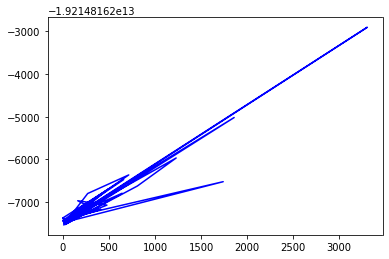

In [22]:
plt.plot(y_test, y_preds, color = 'blue');

In [23]:
lr.score(Xs_train,y_train), lr.score(Xs_test,y_test)

(0.9503280639463727, -1.104322078721621e+21)

Linear regression out of the box is performing poorly on our dataset.

### Lasso

We decide to run Lasso for its high interpretability and coefficent analysis.

In [24]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

In [25]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(0.01, 100, 1000)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas= l_alphas, cv = 100, max_iter= 8000, tol=0.01)
# Fit model using best ridge alpha!
lasso_cv.fit(Xs_train, y_train)

# Here is the optimal value of alpha
lasso_cv.alpha_

1.023292992280754

In [26]:
print(lasso_cv.score(Xs_train, y_train)),
print(lasso_cv.score(Xs_test, y_test))

0.949811902683501
0.7037425663729171


Crossvalidation scores appear interesting, although the model appears overfit.

In [27]:
lasso = Lasso(lasso_cv.alpha_, max_iter= 5000, tol=0.001)

In [28]:
lasso.fit(Xs_train, y_train)

Lasso(alpha=1.023292992280754, max_iter=5000, tol=0.001)

In [29]:
lasso_score = cross_val_score(lasso, Xs_train, y_train, cv=10)

In [30]:
print(lasso_score)
print(np.mean(lasso_score))

[0.44847761 0.07425859 0.74004952 0.92798007 0.81545046 0.93074134
 0.66771088 0.79506964 0.87952277 0.90290081]
0.7182161683644762


In [31]:
coefs = lasso.coef_

In [32]:
cf_list = list(sorted(zip(coefs, X_test.columns), reverse=True))
cf_list

[(231.98561368224685, 'civ_cases'),
 (135.20841436154487, 'total_prisoner_cases'),
 (34.8209834742863, 'civ_tests'),
 (28.931722408802692, 'civ_death'),
 (10.705450089642381, 'name_Ohio'),
 (8.81706948839479, 'name_Missouri'),
 (7.987077168721889, 'name_Maryland'),
 (6.706113463485238, 'total_prisoner_deaths'),
 (6.295602330638244, 'name_Delaware'),
 (5.286051400867148, 'name_Virginia'),
 (3.8504614170134794, 'name_Hawaii'),
 (3.5545716783917407, 'name_New Mexico'),
 (3.160344644087138, 'name_Wyoming'),
 (2.974561626852338, 'region_Northeast'),
 (2.688086036897549, 'Latitude'),
 (2.207323932718706, 'name_Connecticut'),
 (1.6513714469745457, 'name_Oregon'),
 (1.2911228283275868, 'name_North Carolina'),
 (1.2149483431094057, 'name_Nevada'),
 (0.9532966800565802, 'name_West Virginia'),
 (0.7452732329717414, 'name_Vermont'),
 (0.4786729035782846, 'name_Montana'),
 (0.4569488165938625, 'name_Maine'),
 (0.407462609340062, 'name_North Dakota'),
 (0.10918836713131919, 'name_Rhode Island'),
 (0

Prisoners and civilian cases appear to have the highest weight in predicting the number of staff covid19 cases. 

### Ridge

Also we ran a Ridge model, cross validating it. We expect the results to be in the same range of performance as Lasso.

In [33]:
from sklearn.linear_model import Ridge, RidgeCV

In [34]:
r_alphas = np.logspace(0,5,100) #alphase from 1 to 10ˆ5

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas= r_alphas,
  scoring= 'r2',
  cv = 5)

In [35]:
ridge_cv.fit(Xs_train, y_train);

In [36]:
ridge_cv.alpha_# Here is the optimal value of alpha

32.74549162877728

In [37]:
#Now adding alpha in my model
# Instantiate.
ridge_model = Ridge(alpha = ridge_cv.alpha_)
# Fit.
ridge_model.fit(Xs_train, y_train)

Ridge(alpha=32.74549162877728)

In [38]:
print(ridge_model.score(Xs_train, y_train))
print(ridge_model.score(Xs_test, y_test))

0.9467592244465736
0.7718292877922341


Model appears indeed overfit but still scores well on both train and test data. 

## Random Forest

Random forest regressor is a model we believe can work well with our dataset. Even if it tends to overfit, the fact that many features values are replicated by state could improve the model ability to create meaningful splits, resulting in better predictions.

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [40]:
rf = RandomForestRegressor(random_state = 42)
rf.fit(Xs_train, y_train)

rf_pred = rf.predict(Xs_test) 
print(f'Score on training set: {rf.score(Xs_train, y_train)}')
print(f'Score on testing set: {rf.score(Xs_test, y_test)}')

Score on training set: 0.9513634042681877
Score on testing set: 0.894061689805662


The out of the box model performs really well.

In [92]:
rmse_rf = mean_squared_error(y_test, rf_pred)
rmse_rf

66785.77977408074

We try to run a gridsearch to optimize the values and test if we an imrpove the variae registered by the out of the box model scores.

In [41]:
rf_params = {
    'n_estimators': [50 ,150, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [2, 3],
    'max_features': ['auto', 'log2']
}
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs = 1, verbose = True)
gs_rf.fit(Xs_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
0.6763542972549992


{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 50}

In [42]:
gs_rf_pred = gs_rf.predict(Xs_test)

In [43]:
rf_best = RandomForestRegressor(max_depth = 50,
 max_features = 'auto',
 min_samples_leaf = 3,
 min_samples_split = 2,
 n_estimators = 50, random_state= 1)

In [44]:
rf_best.fit(Xs_train, y_train)

rf_pred = rf_best.predict(Xs_test) 
print(f'Score on training set: {rf_best.score(Xs_train, y_train)}')
print(f'Score on testing set: {rf_best.score(Xs_test, y_test)}')

Score on training set: 0.7789690403833539
Score on testing set: 0.8002405715698089


The model resulting from the gridsearch scores higher on test than train.

## Bagged Decision Tree

As per Random Forest, also bagged decision tree an perform well on our data in our expectations.

In [45]:
from sklearn.ensemble import BaggingRegressor

In [46]:
bg = BaggingRegressor()
bg.fit(Xs_train, y_train)

BaggingRegressor()

In [47]:
bg_pred = bg.predict(Xs_test) 
print(f'Score on training set: {bg.score(Xs_train, y_train)}')
print(f'Score on testing set: {bg.score(Xs_test, y_test)}')

Score on training set: 0.9565342590239402
Score on testing set: 0.8910198815645994


The out of the box model does great but we decide to run a gridsearch trying to combat overfit.

In [48]:
bag_params = {
    'n_estimators': [20, 25, 50],
    'max_samples': [0.5, 0.75, 0.9],
    'max_features': [0.5, 0.75, 0.9],
    'bootstrap_features': [True, False]
}
gs_bag = GridSearchCV(bg, param_grid=bag_params, cv=5, n_jobs = 1, verbose = True)
gs_bag.fit(Xs_train, y_train)
print(gs_bag.best_score_)
gs_bag.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
0.7276518631243618


{'bootstrap_features': True,
 'max_features': 0.75,
 'max_samples': 0.75,
 'n_estimators': 25}

In [49]:
bg_best = BaggingRegressor(bootstrap_features = True,
 max_features = 0.9,
 max_samples = 0.5,
 n_estimators = 25, random_state=1)

bg_best.fit(Xs_train, y_train);

In [50]:
bg_best_pred = bg_best.predict(Xs_test) 
print(f'Score on training set: {bg_best.score(Xs_train, y_train)}')
print(f'Score on testing set: {bg_best.score(Xs_test, y_test)}')

Score on training set: 0.7716505486659219
Score on testing set: 0.747251161090317


The gridsearched model results having worse performances overall, but signifiantly improving the variance of 3 percentage points.

## K Neighbors Regressor

Considering how lustered our data might appear by state, we decide to run a KNN Regressor.

In [51]:
from sklearn.neighbors import KNeighborsRegressor

In [52]:
knn = KNeighborsRegressor()

knn.fit(Xs_train, y_train)
print(f'Score on training set: {knn.score(Xs_train, y_train)}')
print(f'Score on testing set: {knn.score(Xs_test, y_test)}')

Score on training set: 0.633393030372861
Score on testing set: 0.6354384284178766


The results on the out of the box model are lower than other models ran so far, but the variace is very low. We believe that having more months of data this model could really give reliable results.

In [85]:
knn_params = {
    'n_neighbors': (10, 15, 20),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights' : ['uniform', 'distance']
}

# Instantiate our GridSearchCV object.
knn_gs = GridSearchCV(knn, 
                              knn_params, 
                              cv = 10, 
                              verbose=1)
                              
# Fit the GridSearchCV object to the data
knn_gs.fit(Xs_train, y_train)
# Print out the set of hyperparameters that achieved the best score.
knn_gs.best_params_

Fitting 10 folds for each of 18 candidates, totalling 180 fits


{'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'}

In [86]:
knn_best = KNeighborsRegressor(metric = 'euclidean',
                         n_neighbors = 20,
                         weights= 'distance')

knn_best.fit(Xs_train, y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=20, weights='distance')

In [87]:
knn_pred = knn_best.predict(Xs_test) 
print(f'Score on training set: {knn_best.score(Xs_train, y_train)}')
print(f'Score on testing set: {knn_best.score(Xs_test, y_test)}')

Score on training set: 1.0
Score on testing set: 0.4728112062813762


We did run a gridsearch, but it seemed to optimize the results on train decreasing heavily the performance on test data.

## Neural Network

We tired to run a Neural Network regressor.

After a few iterations we decided for a 3 layers structure.

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor

In [57]:
def model_func(layer_one_neurons = 8, layer_two_neurons = 8, layer_three_neurons = 8):
    model = Sequential()
    #layer 1
    model.add(Dense(layer_one_neurons,
                   activation = 'relu',
                   input_shape = (Xs_train[0].shape)))

    #layer 2
    model.add(Dense(layer_two_neurons, activation = 'relu'))
    
    #layer 3
    model.add(Dense(layer_three_neurons, activation = 'relu'))

    #output layer
    model.add(Dense(1, activation = 'linear'))

    #Compile model
    model.compile(loss= 'mse', optimizer = 'adam')

    return model

In [58]:
Xs_train[0].shape

(86,)

In [59]:
nn = KerasRegressor(build_fn = model_func, batch_size =  512, epochs = 10, verbose = 0)

params = {'layer_one_neurons': [32, 64, 128],
          'layer_two_neurons': [64, 128, 192],
          'layer_three_neurons': [32, 64, 128],
          'batch_size': [512, 1024, 1536],
          'epochs': [200, 300, 400]}

gs = GridSearchCV (nn, params, cv = 3)

Set neural network gridseach parameters, as result of multiple iterations, we can now proceed to fit our Neural Network.

In [60]:
gs.fit(Xs_train, y_train)

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fa372b20d30>,
             param_grid={'batch_size': [512, 1024, 1536],
                         'epochs': [200, 300, 400],
                         'layer_one_neurons': [32, 64, 128],
                         'layer_three_neurons': [32, 64, 128],
                         'layer_two_neurons': [64, 128, 192]})

In [61]:
print (gs.best_score_)
gs.best_params_

-16587.0712890625


{'batch_size': 512,
 'epochs': 300,
 'layer_one_neurons': 128,
 'layer_three_neurons': 128,
 'layer_two_neurons': 64}

In [66]:
model = Sequential()
    #layer 1
model.add(Dense(128,
                activation = 'relu',
                input_shape = (Xs_train[0].shape)))

    #layer 2
model.add(Dense(64, activation = 'relu'))

    #layer 3
model.add(Dense(128, activation = 'relu'))

    #output layer
model.add(Dense(1, activation = 'linear'))

    #Compile model
model.compile(loss= 'mse', optimizer = 'adam', metrics = ['mae'])
    
history_s =  model.fit(Xs_train, y_train, validation_data = (Xs_test, y_test), epochs = 300, batch_size = 1536)

Epoch 1/300
1/1 [==============================] - 0s 412ms/step - loss: 171138.2500 - mae: 164.8984 - val_loss: 454435.8750 - val_mae: 347.6702
Epoch 2/300
1/1 [==============================] - 0s 32ms/step - loss: 170928.4219 - mae: 164.6080 - val_loss: 453902.8750 - val_mae: 347.3506
Epoch 3/300
1/1 [==============================] - 0s 33ms/step - loss: 170711.5312 - mae: 164.3129 - val_loss: 453350.8125 - val_mae: 347.0224
Epoch 4/300
1/1 [==============================] - 0s 34ms/step - loss: 170483.4062 - mae: 164.0088 - val_loss: 452767.1875 - val_mae: 346.6797
Epoch 5/300
1/1 [==============================] - 0s 35ms/step - loss: 170241.7812 - mae: 163.6928 - val_loss: 452139.7188 - val_mae: 346.3126
Epoch 6/300
1/1 [==============================] - 0s 33ms/step - loss: 169983.3750 - mae: 163.3626 - val_loss: 451472.0312 - val_mae: 345.9206
Epoch 7/300
1/1 [==============================] - 0s 34ms/step - loss: 169707.0156 - mae: 163.0146 - val_loss: 450752.1875 - val_mae: 

Epoch 58/300
1/1 [==============================] - 0s 34ms/step - loss: 74025.6953 - mae: 135.0516 - val_loss: 89181.7500 - val_mae: 143.0244
Epoch 59/300
1/1 [==============================] - 0s 32ms/step - loss: 72876.0703 - mae: 134.1393 - val_loss: 87859.9922 - val_mae: 142.4500
Epoch 60/300
1/1 [==============================] - 0s 36ms/step - loss: 71488.1406 - mae: 132.6257 - val_loss: 87404.2109 - val_mae: 142.5160
Epoch 61/300
1/1 [==============================] - 0s 35ms/step - loss: 69948.4062 - mae: 130.6786 - val_loss: 87646.3594 - val_mae: 143.0768
Epoch 62/300
1/1 [==============================] - 0s 35ms/step - loss: 68342.8125 - mae: 128.4027 - val_loss: 88406.4766 - val_mae: 143.9827
Epoch 63/300
1/1 [==============================] - 0s 34ms/step - loss: 66761.6875 - mae: 125.9333 - val_loss: 89541.2500 - val_mae: 145.1364
Epoch 64/300
1/1 [==============================] - 0s 34ms/step - loss: 65259.3203 - mae: 123.3932 - val_loss: 90886.1562 - val_mae: 146.3628

Epoch 173/300
1/1 [==============================] - 0s 32ms/step - loss: 4069.9019 - mae: 38.2792 - val_loss: 92429.9062 - val_mae: 151.5397
Epoch 174/300
1/1 [==============================] - 0s 34ms/step - loss: 4036.0249 - mae: 38.1256 - val_loss: 92334.2891 - val_mae: 151.1421
Epoch 175/300
1/1 [==============================] - 0s 34ms/step - loss: 4003.1211 - mae: 37.9824 - val_loss: 92235.7500 - val_mae: 150.7449
Epoch 176/300
1/1 [==============================] - 0s 34ms/step - loss: 3972.7461 - mae: 37.8531 - val_loss: 92128.3516 - val_mae: 150.3509
Epoch 177/300
1/1 [==============================] - 0s 33ms/step - loss: 3944.1365 - mae: 37.7295 - val_loss: 92006.0234 - val_mae: 149.9532
Epoch 178/300
1/1 [==============================] - 0s 35ms/step - loss: 3916.4907 - mae: 37.6111 - val_loss: 91881.9688 - val_mae: 149.5606
Epoch 179/300
1/1 [==============================] - 0s 33ms/step - loss: 3891.1897 - mae: 37.5006 - val_loss: 91773.7578 - val_mae: 149.1832
Epoch 

Epoch 231/300
1/1 [==============================] - 0s 34ms/step - loss: 3143.1343 - mae: 33.7771 - val_loss: 90698.4531 - val_mae: 138.8764
Epoch 232/300
1/1 [==============================] - 0s 34ms/step - loss: 3134.5286 - mae: 33.7284 - val_loss: 90647.7031 - val_mae: 138.7280
Epoch 233/300
1/1 [==============================] - 0s 33ms/step - loss: 3125.7646 - mae: 33.6797 - val_loss: 90590.8125 - val_mae: 138.5712
Epoch 234/300
1/1 [==============================] - 0s 34ms/step - loss: 3117.0115 - mae: 33.6321 - val_loss: 90519.3594 - val_mae: 138.4114
Epoch 235/300
1/1 [==============================] - 0s 34ms/step - loss: 3108.6770 - mae: 33.5859 - val_loss: 90439.8203 - val_mae: 138.2560
Epoch 236/300
1/1 [==============================] - 0s 30ms/step - loss: 3100.4028 - mae: 33.5376 - val_loss: 90355.9375 - val_mae: 138.1070
Epoch 237/300
1/1 [==============================] - 0s 31ms/step - loss: 3091.9644 - mae: 33.4873 - val_loss: 90283.2734 - val_mae: 137.9825
Epoch 

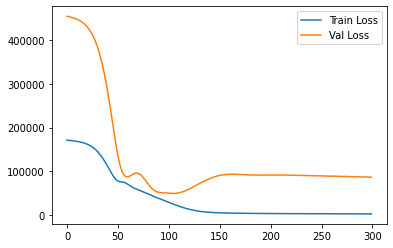

In [67]:
#pyplot loss
plt.plot(history_s.history['loss'], label='Train Loss')
plt.plot(history_s.history['val_loss'], label='Val Loss')
plt.legend();

An early stop around epoch 110 would pobably improve the model, as both MAE and MSE values start diverging.

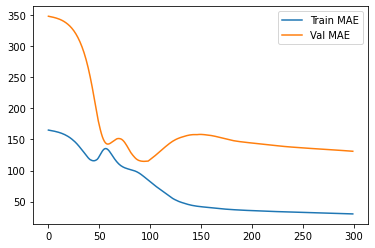

In [68]:
#pyplot accuracy
plt.plot(history_s.history['mae'], label='Train MAE')
plt.plot(history_s.history['val_mae'], label='Val MAE')
plt.legend();

We should set an early stop

## Results

Below we collect all results for the models ran in this notebook.

In [88]:
print(f'COVID-19 Cases Staff')
print(f' ')
print(f'Lasso')
print(f'Score on training set:{round(lasso_cv.score(Xs_train, y_train), 3)}'),
print(f'Score on test set:{round(lasso_cv.score(Xs_test, y_test), 3)}')
print(f' ')
print(f'Ridge')
print(f'Score on training set: {round(ridge_model.score(Xs_train, y_train), 3)}')
print(f'Score on testing set: {round(ridge_model.score(Xs_test, y_test), 3)}')
print(f' ')
print(f'Random Forest - Out of the box')
print(f'Score on training set: {round(rf.score(Xs_train, y_train), 3)}')
print(f'Score on testing set: {round(rf.score(Xs_test, y_test), 3)}')
print(f' ')
print(f'Random Forest - Gridsearch')
print(f'Score on training set: {round(rf_best.score(Xs_train, y_train), 3)}')
print(f'Score on testing set: {round(rf_best.score(Xs_test, y_test), 3)}')
print(f' ')
print(f'Bagged Decision Tree')
print(f'Score on training set: {round(bg_best.score(Xs_train, y_train), 3)}')
print(f'Score on testing set: {round(bg_best.score(Xs_test, y_test), 3)}')
print(f' ')
print(f'K Neighbors Regressor - Gridsearch')
print(f'Score on training set: {round(knn_best.score(Xs_train, y_train), 3)}')
print(f'Score on testing set: {round(knn_best.score(Xs_test, y_test), 3)}')
print(f' ')
print(f'K Neighbors Regressor - Out of the box')
print(f'Score on training set: {round(knn.score(Xs_train, y_train), 3)}')
print(f'Score on testing set: {round(knn.score(Xs_test, y_test), 3)}')

COVID-19 Cases Staff
 
Lasso
Score on training set:0.95
Score on test set:0.704
 
Ridge
Score on training set: 0.947
Score on testing set: 0.772
 
Random Forest - Out of the box
Score on training set: 0.951
Score on testing set: 0.894
 
Random Forest - Gridsearch
Score on training set: 0.779
Score on testing set: 0.8
 
Bagged Decision Tree
Score on training set: 0.772
Score on testing set: 0.747
 
K Neighbors Regressor - Gridsearch
Score on training set: 1.0
Score on testing set: 0.473
 
K Neighbors Regressor - Out of the box
Score on training set: 0.633
Score on testing set: 0.635


Random Forest appears as the model capable of achieving the best results while also minimizing variance.